# V.1 Exploring the green reds

#### a) Fucntion to plot scatter matrix:

In [32]:
%matplotlib inline

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec


def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    cols = wine_data.columns[:-1]

    matrix = plt.figure("Scatter Matrix", figsize=(24, 12))
    gs = gridspec.GridSpec(len(cols), len(cols), width_ratios=[1 for i in range(len(cols))],
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    for i in range(len(cols)):
        for j in range(len(cols)):
            plt.subplot(gs[i, j])
            if i == j:
                plt.text(0.5, 0.5, cols[i], horizontalalignment='center',
                         verticalalignment='center', fontsize=11, fontweight='medium')
                plt.tick_params(
                    labelleft=False,
                    labelbottom=False,
                    bottom=False,
                    top=False,
                    left=False,
                    right=False)
                continue


            x_good, y_good = wine_data.loc[wine_data['quality'] >= good_threshold][cols[j]], \
                               wine_data.loc[wine_data['quality'] >= good_threshold][cols[i]]

            plt.scatter(x_good, y_good, color='blue', s=10, alpha=0.5)

            x_bad, y_bad = wine_data.loc[wine_data['quality'] <= bad_threshold][cols[j]], \
                             wine_data.loc[wine_data['quality'] <= bad_threshold][cols[i]]

            plt.scatter(x_bad, y_bad, color='red', s=10, alpha=0.5)
            plt.tick_params(
                labelleft=False,
                labelbottom=False,
                bottom=False,
                top=False,
                left=False,
                right=False)
    plt.show()
    if save_plot:
        matrix.savefig('plot_scatter_matrix.png', quality=90)


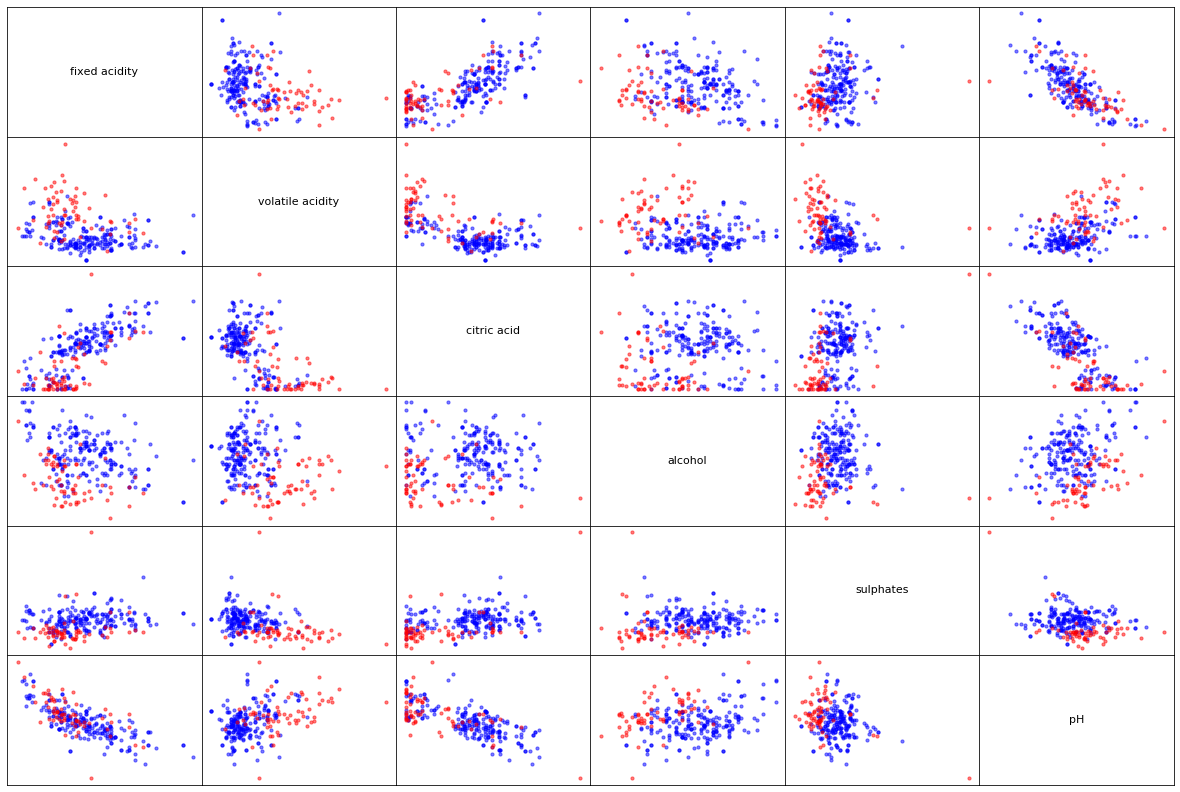

In [34]:
red_wine_data = pd.read_csv("winequality-red.csv", sep=';')
plot_scatter_matrix(red_wine_data.iloc[:, [0, 1, 2, 10, 9, 8, 11]], 7, 4, save_plot=False)

#### b)What factors will be most useful for distinguishing high quality vs. low quality wines?

 I think the best features would be alcohol, sulphates and pH. Its because they divide our data well linearly.

# V.2 Learning to perceptron

#### a) & b) Implemention of a perceptron:

In [35]:
import random

def perceptron(row, weights):
    activation = weights[0]
    for i in range(len(weights) - 1):
        activation += weights[i + 1] * row[i]
    return 1.0 if activation >= 0 else 0.0


def train_perceptron(l_rate, data, n_epochs):
    performance = []
#     random.seed(1000)
    weights = [random.uniform(-1, 1) for i in range(len(data.columns))]
    if n_epochs == 0:
        epoch = 0
        while True:
            sum_error = 0.0
            for i in range(len(data)):
                prediction = perceptron(data.iloc[i, :], weights)
                error = prediction - data.iloc[i, -1]
                sum_error += error ** 2
                weights[0] = weights[0] - l_rate * error
                for j in range(len(data.columns) - 1):
                    weights[j + 1] = weights[j + 1] - l_rate * error * data.iloc[i, j]
            performance.append((epoch, sum_error, weights[1:], weights[0]))
            if sum_error == 0:
                break
            epoch += 1
    else:
        for epoch in range(n_epochs):
            sum_error = 0.0
            for i in range(len(data)):
                prediction = perceptron(data.iloc[i, :], weights)
                error = data.iloc[i, -1] - prediction
                sum_error += error**2
                weights[0] += l_rate * error
                for j in range(len(data.columns) - 1):
                    weights[j + 1] = weights[j + 1] + l_rate * error * data.iloc[i, j]
            performance.append((epoch, sum_error, weights[1:], weights[0]))
    return performance

In [36]:
red_wine_data = pd.read_csv("winequality-red.csv", sep=';')

train_data = red_wine_data.loc[:, ['alcohol', 'pH', 'quality']].copy()

train_data = train_data.loc[(train_data['quality'] == 8) | (train_data['quality'] == 3)]
train_data['binary_quality'] = train_data['quality'].map({8: 1, 3: 0})
performance = train_perceptron(0.1, train_data.loc[:, ['alcohol', 'pH', 'binary_quality']], 3000)

#### c) Performance plot

In [37]:
from math import ceil, floor


def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    """
    fig = plt.figure("Perfoкmance", figsize=(12, 6))

    plt.subplot(121)

    y = [epoch[1] for epoch in performance]
    x = range(len(performance))

    plt.plot(x, y, color='blue')
#     plt.fill_between(x, 0, y, facecolor='blue')
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Errors as function of epoch')

    plt.subplot(122)
    x_good, y_good = wine_data.loc[wine_data['quality'] >= good_thresh]['alcohol'], \
                     wine_data.loc[wine_data['quality'] >= good_thresh]['pH']
    x_bad, y_bad = wine_data.loc[wine_data['quality'] <= bad_thresh]['alcohol'], \
                   wine_data.loc[wine_data['quality'] <= bad_thresh]['pH']
    plt.scatter(x_good, y_good, color='green', s=10)
    plt.scatter(x_bad, y_bad, color='magenta', s=10)

    output_epoch = performance[-1] if epoch == -1 else performance[epoch]

    min_x = min(min(x_good), min(x_bad))
    max_x = max(max(x_good), max(x_bad))
    min_y = min(min(y_good), min(y_bad))
    max_y = max(max(y_good), max(y_bad))
    
    x_line = [i for i in range(floor(min_x) - 1, ceil(max_x) + 2)]
    y_line = [(-1) * (output_epoch[-1] + output_epoch[-2][0] * x) / output_epoch[-2][-1] for x in x_line]
    
    plt.plot(x_line, y_line, linestyle='dashed', color='blue', alpha=0.7)
    
    plt.fill_between(x_line, min(y_line), y_line, facecolor='green', alpha=0.3)
    plt.fill_between(x_line, max(y_line), y_line, facecolor='magenta', alpha=0.2)
    
    plt.xlim(min_x - min_x * 0.05, max_x + max_x * 0.05)
    plt.ylim(min_y - min_y * 0.05, max_y + max_y * 0.05)

    plt.xlabel('alcohol')
    plt.ylabel('pH')
    plt.title('Decision boundary on epoch: ' + str(output_epoch[0]))
    plt.legend(['Decision Boundary', 'good wines (>' + str(good_thresh - 1) + ' score)',
                'bad wines (<' + str(bad_thresh + 1) + ' score)'],
               loc=2, bbox_to_anchor=(1.02, 0.98), borderaxespad=0.0)

    plt.show()
    if save_plot:
        fig.savefig('plot_scatter_matrix.png', quality=90)

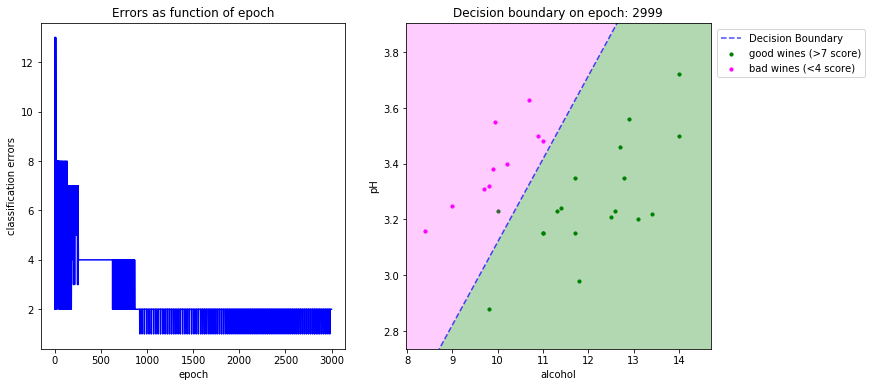

In [38]:
plot_performance(performance, train_data, 8, 3, epoch=performance[-1][0], save_plot=False)

#### d) Scaling the data and performance plot after scaling

In [39]:
def col_min_max(col):
    """calculates the min and max value"""
    min_value = col.iloc[0]
    max_value = col.iloc[0]
    for x in col:
        if x > max_value:
            max_value = x
        if x < min_value:
            min_value = x
    return min_value, max_value


def normalizing(data):
    """rescale data values to the range between 0 and 1"""
    for j in range(data.shape[1]):
        min_value, max_value = col_min_max(data.iloc[:, j])
        for i in range(len(data)):
            data.iloc[i, j] = (data.iloc[i, j] - min_value) / (max_value - min_value)
    return data

In [10]:
train_data.iloc[:, :-2] = normalizing(train_data.iloc[:, :-2])
performance_normalized = train_perceptron(0.01, train_data.loc[:, ['alcohol', 'pH', 'binary_quality']], 0)
plot_performance(performance_normalized, train_data, 8, 3, epoch=performance_normalized[-1][0], save_plot=False)

NameError: name 'train_data' is not defined

# V.3 My fair ADALINE
#### a) Why perceptron doesn't work  on wines with a score of 4 and lower, and wines with a score of 7 and higher?

It doesn't work ,because in this example data is not linearly separable. And perceptron can't find the line that will completely separate the data. So here should be the algorythm that can optimize the weights and find the line with the least error.

#### b) & c) Adaline implemantation

In [40]:
def accuracy_score(weight_values, data):
    right_answers = 0
    for i in range(len(data)):
        prediction = quantizer(data.iloc[i, :], weight_values)
        if prediction == data.iat[i, -1]:
            right_answers += 1
    return right_answers / len(data)


def activation_calc(row, weights):
    activation = weights[0]
    for i in range(len(weights) - 1):
        activation += weights[i + 1] * row[i]
    return activation


def shuffle_data(data):
    index_list = [i for i in range(len(data))]
    random.shuffle(index_list)
    data = data.iloc[index_list, :]
    data.reset_index(inplace=True, drop=True)
    return data


def quantizer(row, classifier_weights):
    activation = activation_calc(row, classifier_weights)
    return 1 if activation >= 0 else -1


def adaline_train(l_rate, data, n_epochs, mode='online'):
    """function that trains adaline's weights"""
    performance = []
    random.seed(999)
    weights = [random.uniform(-1, 1) for i in range(len(data.columns))]
    if mode == 'batch':
        epoch = 0
        while True:
            data = shuffle_data(data)
            product_x_e = [0 for i in range(len(weights))]
            sum_error = 0.0
            for i in range(len(data)):
                activation = activation_calc(data.iloc[i, :], weights)
                error = activation - data.iat[i, -1]
                sum_error += error ** 2
                product_x_e[0] += error
                for j in range(len(data.columns) - 1):
                    product_x_e[j + 1] += error * data.iat[i, j]
            for k in range(len(weights)):
                weights[k] -= ((2 * l_rate) / len(data)) * product_x_e[k]
            performance.append((epoch, sum_error, weights[1:], weights[0]))
            if n_epochs == 0 and epoch >= 500 and abs(sum_error - performance[-150][1]) < 0.001 * sum_error:
                break
            if n_epochs != 0 and epoch == n_epochs:
                break
            epoch += 1

    elif mode == 'online':
        epoch = 0
        while True:
            sum_error = 0.0
#             data = shuffle_data(data)
            for i in range(len(data)):
                activation = activation_calc(data.iloc[i, :], weights)
                error = activation - data.iat[i, -1]
                sum_error += error ** 2
                weights[0] = weights[0] - (2 * l_rate * error)
                for j in range(len(data.columns) - 1):
                    weights[j + 1] = weights[j + 1] - (2 * l_rate * error * data.iat[i, j])
            performance.append((epoch, sum_error, weights[1:], weights[0]))
            if n_epochs == 0 and epoch >= 200 and abs(sum_error - performance[-50][1]) < 0.005 * sum_error:
                break
            if n_epochs != 0 and epoch == n_epochs:
                break
            epoch += 1

    return performance

def adaline_plot(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    fig = plt.figure("Performance", figsize=(12, 6))

    plt.subplot(121)

    y = [epoch[1] for epoch in performance]
    x = range(len(performance))

    plt.plot(x, y, color='blue')
#     plt.fill_between(x, 0, y, facecolor='blue')
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Errors as function of epoch')

    plt.subplot(122)
    x_good, y_good = wine_data.loc[wine_data['quality'] >= good_thresh][wine_data.columns[0]], \
                     wine_data.loc[wine_data['quality'] >= good_thresh][wine_data.columns[1]]
    x_bad, y_bad = wine_data.loc[wine_data['quality'] <= bad_thresh][wine_data.columns[0]], \
                   wine_data.loc[wine_data['quality'] <= bad_thresh][wine_data.columns[1]]
    plt.scatter(x_good, y_good, color='green', s=10)
    plt.scatter(x_bad, y_bad, color='magenta', s=10)

    output_epoch = performance[-1] if epoch == -1 else performance[epoch]

    weights = [output_epoch[-1]]
    weights.extend(output_epoch[2])

    min_x = min(min(x_good), min(x_bad))
    max_x = max(max(x_good), max(x_bad))
    min_y = min(min(y_good), min(y_bad))
    max_y = max(max(y_good), max(y_bad))
    x_line = [i for i in range(floor(min_x) - 1, ceil(max_x) + 2)]
    y_line = [(-1) * (weights[0] + weights[1] * x) / weights[2] for x in x_line]
    plt.plot(x_line, y_line, linestyle='dashed', color='blue', alpha=0.7)
    under_line_class = quantizer([x_line[len(x_line) // 2], y_line[len(x_line) // 2] - 0.5], weights)
    if under_line_class == -1:
        plt.fill_between(x_line, min_y - 0.1, y_line, facecolor='magenta', alpha=0.3)
        plt.fill_between(x_line, max_y + 0.1, y_line, facecolor='green', alpha=0.2)
    else:
        plt.fill_between(x_line, min_y - 0.1, y_line, facecolor='green', alpha=0.2)
        plt.fill_between(x_line, max_y + 0.1, y_line, facecolor='magenta', alpha=0.3)

    plt.xlabel(wine_data.columns[0])
    plt.ylabel(wine_data.columns[1])
    plt.title('Decision boundary on epoch: ' + str(output_epoch[0]))
    plt.legend(['Decision Boundary', 'good wines (>' + str(good_thresh - 1) + ' score)',
                'bad wines (<' + str(bad_thresh + 1) + ' score)'],
               loc=2, bbox_to_anchor=(1.02, 0.98), borderaxespad=0.0)
    plt.xlim(min_x - min_x * 0.05, max_x + max_x * 0.05)
    plt.ylim(min_y - min_y * 0.05, max_y + max_y * 0.05)

    fig.tight_layout()
    plt.show()
    if save_plot:
        fig.savefig('plot_scatter_matrix.png', quality=90)


Online algorythm(Stohastic gradient descent)

In [ ]:
data = red_wine_data.loc[:, ['alcohol', 'pH', 'quality']].copy()
data = data.loc[(data['quality'] >= 8) | (data['quality'] <= 3)]
data['binary_quality'] = data['quality'].map({8: 1, 3: 0, 7: 1, 4: 0})

# scaling the data
data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

performance = adaline_train(0.005, data.iloc[:, [0, 1, 3]], 400, mode='online')
weights = performance[-1][-2][:]
weights.insert(0, performance[-1][-1])

adaline_plot(performance, data.iloc[:, 0:3], 8, 3)

Batch algorythm

In [24]:
data = red_wine_data.loc[:, ['alcohol', 'pH', 'quality']].copy()
data = data.loc[(data['quality'] >= 7) | (data['quality'] <= 4)]
data['binary_quality'] = data['quality'].map({8: 1, 3: -1, 7: 1, 4: -1})

# scaling the data
data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

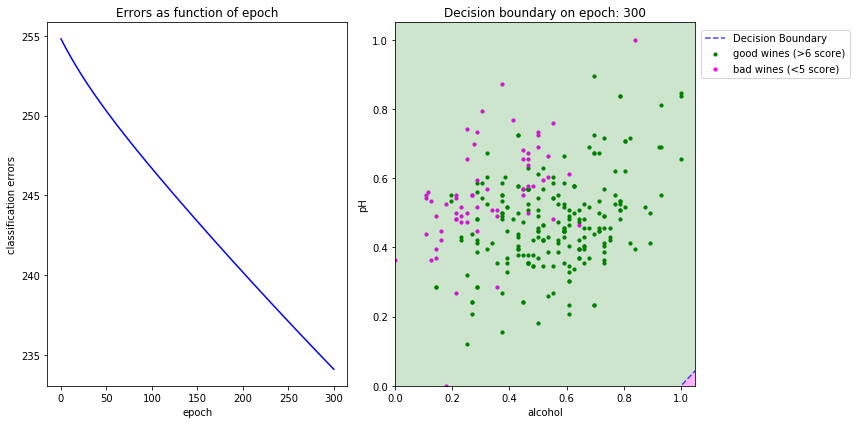

In [25]:
performance = adaline_train(0.005, data.iloc[:, [0, 1, 3]], 300, mode='batch')
weights = performance[-1][-2][:]
weights.insert(0, performance[-1][-1])

# print("accuracy = " + str(accuracy_score(weights, data)))
adaline_plot(performance, data.iloc[:, 0:3], 7, 4)

# V.4 Advanced wine sampling and resampling#
#### a) Function to split the data into training and validation set 

In [41]:
def train_test_split(data, train_ratio=0.8):
    index_list = [i for i in range(len(data))]
    random.shuffle(index_list)
    training_pandas_dataframe = data.iloc[index_list[0: floor(len(data) * train_ratio)], :].copy()
    validation_pandas_dataframe = data.iloc[index_list[floor(len(data) * train_ratio):], :].copy()
    training_pandas_dataframe.reset_index(inplace=True, drop=True)
    validation_pandas_dataframe.reset_index(inplace=True, drop=True)
    return training_pandas_dataframe, validation_pandas_dataframe

In [38]:
train_data, test_data = train_test_split(data)
performance = adaline_train(0.01, train_data.iloc[:, [0, 1, 3]], 0, mode='online')
weights = performance[-1][-2][:]
weights.insert(0, performance[-1][-1])

print("accuracy = " + str(accuracy_score(weights, test_data)))

accuracy = 0.8571428571428571


#### b) Function to make k_fold splitting for cross validation

In [42]:
def k_fold_split(data, k, shuffle=False):
    if k < 2:
        return None
    if shuffle:
        index_list = [i for i in range(len(data))]
        random.shuffle(index_list)
        data = data.iloc[index_list, :]
        data.reset_index(inplace=True, drop=True)
    test_ratio = 1 / k
    result_list = []
    for i in range(k):
        training_pandas_dataframe = data.iloc[: i * floor(test_ratio * len(data)), :].copy().append(data.iloc[(i + 1)
                                                                                            * floor(test_ratio
                                                                                            * len(data)):, :].copy())
        cross_validation_pandas_dataframe = data.iloc[i * floor(test_ratio * len(data)):
                                                      (i + 1) * floor(test_ratio * len(data)), :].copy()
        training_pandas_dataframe.reset_index(inplace=True, drop=True)
        cross_validation_pandas_dataframe.reset_index(inplace=True, drop=True)
        result_list.append((training_pandas_dataframe, cross_validation_pandas_dataframe))
    return result_list

#### c) cross validation function 

In [43]:
def cross_validation(data, training_function, method='online', n_folds=3, l_rate=0.01, n_epochs=1000):
    cross_validation_set = k_fold_split(data, n_folds, shuffle=True)
    overall_score = 0
    counter = 0
    for one_set in cross_validation_set:
        performance = training_function(l_rate, one_set[0], n_epochs, mode=method)
        weights = performance[-1][-2][:]
        weights.insert(0, performance[-1][-1])
        score = accuracy_score(weights, one_set[1])
        overall_score += score
        print("set" + str(counter) + "\t" + "-----> accuracy score: " + str(score))
        counter += 1
    return overall_score / n_folds

In [41]:
score = cross_validation(data.drop('quality', axis=1), adaline_train,
                         n_folds=3, n_epochs=0, method='online', l_rate=0.005)
print("score: " + str(score))

set0	-----> accuracy score: 0.8817204301075269
set1	-----> accuracy score: 0.8064516129032258
set2	-----> accuracy score: 0.8817204301075269
score: 0.8566308243727598


# V.5 Adventures in the Nth dimension #
#### a) Different chemical factors and their quantity

Training on alcohol and sulphates (only 2) chemical factors

In [42]:
data = red_wine_data.loc[:, :].copy()
data = data.loc[(data['quality'] >= 7) | (data['quality'] <= 4)]
data['binary_quality'] = data['quality'].map({8: 1, 3: -1, 7: 1, 4: -1})

# scaling the data
data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

score = cross_validation(data.loc[:, ['alcohol', 'sulphates', 'binary_quality']], adaline_train,
                         n_folds=3, n_epochs=0, method='online', l_rate=0.005)
print("score: " + str(score))

set0	-----> accuracy score: 0.8279569892473119
set1	-----> accuracy score: 0.8817204301075269
set2	-----> accuracy score: 0.8172043010752689
score: 0.8422939068100358


Training on 3 factors (alcohol, pH and sulphates)

In [43]:
score = cross_validation(data.loc[:, ['alcohol', 'sulphates', 'pH', 'binary_quality']], adaline_train,
                         n_folds=3, n_epochs=0, method='online', l_rate=0.005)
print("score: " + str(score))

set0	-----> accuracy score: 0.8602150537634409
set1	-----> accuracy score: 0.8494623655913979
set2	-----> accuracy score: 0.8494623655913979
score: 0.8530465949820788


Training on 6 factors (alcohol, sulphates, pH, citric acid, volatile acidity and chlorides)

In [44]:
score = cross_validation(data.loc[:, ['alcohol', 'sulphates', 'pH', 'citric acid',
                                      'volatile acidity', 'chlorides', 'binary_quality']],
                         adaline_train, n_folds=3, n_epochs=0, method='online', l_rate=0.005)
print("score: " + str(score))

set0	-----> accuracy score: 0.8817204301075269
set1	-----> accuracy score: 0.8924731182795699
set2	-----> accuracy score: 0.9139784946236559
score: 0.8960573476702508


Training on all eleven factors

In [45]:
score = cross_validation(data.drop('quality', axis=1), adaline_train,
                         n_folds=3, n_epochs=0, method='online', l_rate=0.005)
print("score: " + str(score))

set0	-----> accuracy score: 0.8924731182795699
set1	-----> accuracy score: 0.8709677419354839
set2	-----> accuracy score: 0.946236559139785
score: 0.903225806451613


####  Under what circumstances can your perceptron/ADALINE successfully train?
The Adaline trains with a good accuracy score on factors that are the most informative (those who better split data).
The best result was achieved for all 11 factors, because in this case model is learning on the larger amount of information and can better generalize dependence.

#### b) What does the decision boundary for more factors look like? 

In case of 2 factors it looks like plain with boundary line, in case of 3 factors it would be 3 dimensional space with boundary plane. With more quantity of chemical factors it would be something that mathematicians call multidimensional space with boundary hyperplane.

# V.6 Marvin’s rebuttal#
#### a) Training Adaline on the PanGalactic Gargle Blaster data set 

score = 0.67


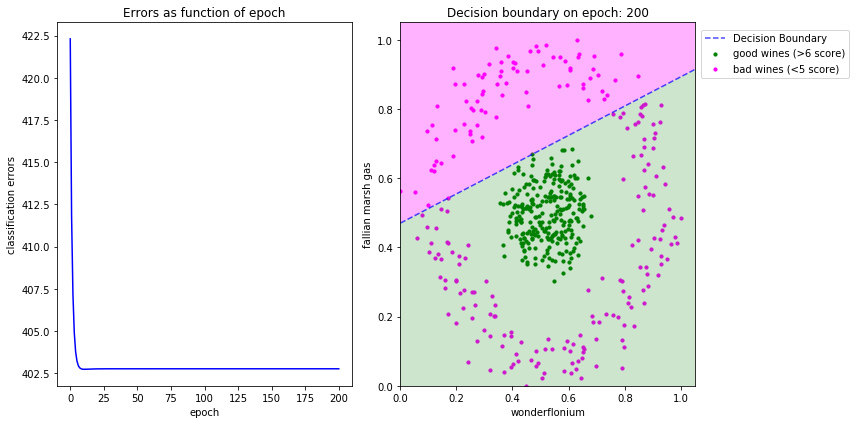

In [18]:
data = pd.read_csv("Pan Galactic Gargle Blaster.csv", sep=';')

data = data.loc[(data['quality'] >= 8) | (data['quality'] <= 2)]
data['binary_quality'] = data['quality'].map({8: 1, 2: -1, 9: 1, 1: -1})

data.iloc[:, :2] = normalizing(data.iloc[:, :2])

train_data, test_data = train_test_split(data)
performance = adaline_train(0.01, train_data.drop('quality', axis=1), 200, mode='online')
last_weights = [performance[-1][-1]]
last_weights.extend(performance[-1][-2])
print("score = " + str(accuracy_score(last_weights, test_data)))
adaline_plot(performance, data.iloc[:, 0:3], 7, 4)

In [19]:
score = cross_validation(data.drop('quality', axis=1), adaline_train,
                         n_folds=3, n_epochs=0, method='online', l_rate=0.005)
print("score = " + str(score))

NameError: name 'cross_validation' is not defined

Very bad score. But we can make some data preprocessing (after seeing how our data is distributed)).

In [ ]:
plot_scatter_matrix(data.iloc[:, :-1], 7, 4, save_plot=False)

For example ,we can add 2 new columns that will be the result of some calculations. First column called 'radius':

$r = \sqrt{(feature1 - centerpointx)^2 + (feature2 - centerpointy)^2}$

It is clear that second would be angle(theta):

$\theta = \arctan{\Bigl(\frac {feature1}{feature2}\Bigl)}$

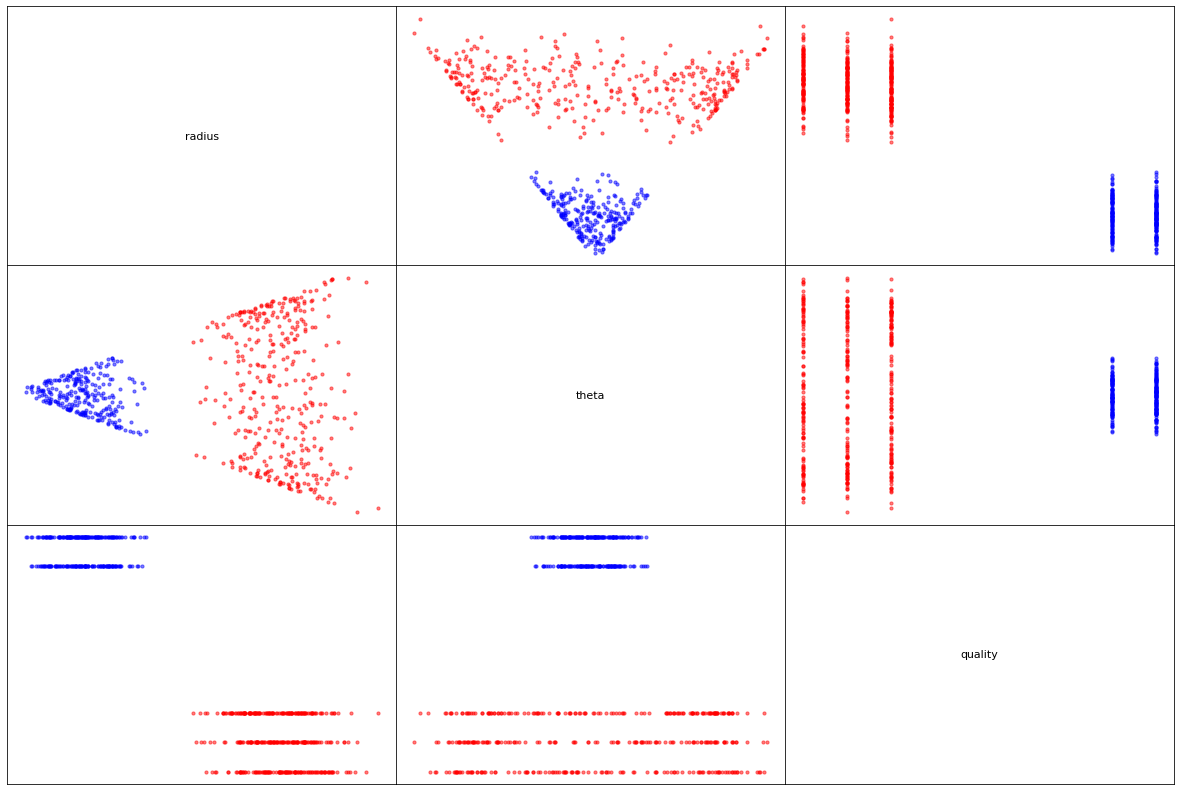

In [44]:
import math


data = pd.read_csv("Pan Galactic Gargle Blaster.csv", sep=';')
data['radius'] = 0.0
data['theta'] = 0.0
cols = data.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[2:3]
data = data[cols]
bad_blasters = data.loc[data['quality'] <= 3]
new_x_0 = bad_blasters.iloc[:, 0].mean()
new_y_0 = bad_blasters.iloc[:, 1].mean()
for i in range(data.shape[0]):
    data.iat[i, 2] = math.sqrt((data.iat[i, 0] - new_x_0) ** 2 + (data.iat[i, 1] - new_y_0) ** 2)
    data.iat[i, 3] = math.atan(data.iat[i, 1] / data.iat[i, 0])

data = data.loc[(data['quality'] >= 8) | (data['quality'] <= 3)]
data['binary_quality'] = data['quality'].map({8: 1, 2: -1, 9: 1, 1: -1})

data.drop(data.columns[:2], axis=1, inplace=True)
plot_scatter_matrix(data, 8, 3, save_plot=False)
# data.iloc[:, :2] = normalizing(data.iloc[:, :2])


# train_data, test_data = train_test_split(data)
# performance = adaline_train(0.01, train_data.iloc[:, [0, 1, 3]], 200, mode='online')
# last_weights = [performance[-1][-1]]
# last_weights.extend(performance[-1][-2])
# print("score = " + str(accuracy_score(last_weights, test_data)))
# adaline_plot(performance, data.iloc[:, 0:3], 7, 4)

In [50]:
score = cross_validation(data.drop('quality', axis=1), adaline_train,
                         n_folds=3, n_epochs=0, method='online', l_rate=0.01)
print("score = " + str(score))

set0	-----> accuracy score: 1.0
set1	-----> accuracy score: 1.0
set2	-----> accuracy score: 1.0
score = 1.0


The ideal result! Its because after this preprocessing the data is almost linearly separable as in case of perceptron with wines with scores 8 and 3.

# Bonus part
## VI.1 Gotta go fast!

#### Loading Cython magic for compiling

In [99]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


#### a)Perceptron implementetion in cython

In [45]:
%%cython

from libc.stdlib cimport malloc, free, rand, srand, RAND_MAX
from cpython cimport array
import array
from math import ceil, floor


cdef struct s_perceptron:
    float *weights;
    float bias;
    int n_weights;
ctypedef s_perceptron t_perceptron

cdef struct s_performance:
    int epoch;
    float sum_error;
    float *weights;
    float bias;
    s_performance *next_elem;
ctypedef s_performance t_performance

cdef int heaviside(float activity_sum):
    if (activity_sum >= 0):
        return (1);
    else:
        return (0);
    
cdef float perceptron(float []row, t_perceptron model):
    
    cdef float activation = 0
    activation += model.bias
    cdef int i = 0
    for i in range(model.n_weights):
        activation += model.weights[i] * row[i]
    return heaviside(activation);


cdef t_performance* cython_train_perceptron(float l_rate, float **data, int n_epochs, int []data_shape):
    cdef t_perceptron model
    cdef t_performance *performance_list
    cdef t_performance *temp
    cdef float sum_error
    cdef float prediction
    cdef int epoch
    cdef float error
    
    model.n_weights = data_shape[1] - 1
    model.weights = <float*>malloc(sizeof(float) * model.n_weights)
    performance_list = <t_performance*>malloc(sizeof(t_performance))
    performance_list.weights = <float*>malloc(sizeof(float) * model.n_weights)
#     srand(1000)
    model.bias = rand() / RAND_MAX
    for i in range(model.n_weights):
        model.weights[i] = rand() / RAND_MAX
    epoch = 0
    temp = performance_list
    while True:
        sum_error = 0
        for i in range(data_shape[0]):
            prediction = perceptron(data[i], model)
            error = prediction - data[i][data_shape[1] - 1]
            sum_error += error * error
            model.bias = model.bias - l_rate * error
            for j in range(model.n_weights):
                model.weights[j] = model.weights[j] - l_rate * error * data[i][j]
        temp.epoch = epoch
        temp.sum_error = sum_error
        for i in range(model.n_weights):
            temp.weights[i] = model.weights[i]
        temp.bias = model.bias
        if (n_epochs == 0 and sum_error == 0) or (n_epochs != 0 and epoch == n_epochs):
            temp.next_elem = NULL
            break
        temp.next_elem = <t_performance*>malloc(sizeof(t_performance))
        temp = <t_performance*>temp.next_elem
        temp.weights = <float*>malloc(sizeof(float) * model.n_weights)
        epoch += 1
    free(model.weights)
    return performance_list

def perceptron_cython_train(float l_rate, data, int n_epochs):
    cdef t_performance *cperformance
    cdef t_performance *temp
    
    cdef float **cdata = <float**>malloc(sizeof(float*) * data.shape[0])
    for i in range(data.shape[0]):
        cdata[i] = <float*>malloc(sizeof(float) * data.shape[1])
        for j in range(data.shape[1]):
            cdata[i][j] = data.iat[i, j]
    
    cdef int [2]data_shape;
    data_shape[0] = data.shape[0]
    data_shape[1] = data.shape[1]
    cperformance = cython_train_perceptron(l_rate, cdata, n_epochs, data_shape)
    for i in range(data.shape[0]):
        free(cdata[i])
    free(cdata)
    performance = []
    while cperformance != NULL:
        temp = cperformance
        weights_list = [temp.weights[i] for i in range(data.shape[1] - 1)]
        performance.append((temp.epoch, temp.sum_error, weights_list, temp.bias))
        cperformance = cperformance.next_elem
        free(temp.weights)
        free(temp)
    return performance

UsageError: Cell magic `%%cython` not found.


In [ ]:
red_wine_data = pd.read_csv("resources/winequality-red.csv", sep=';')

train_data = red_wine_data.loc[:, ['alcohol', 'pH', 'quality']].copy()

train_data = train_data.loc[(train_data['quality'] == 8) | (train_data['quality'] == 3)]
train_data['binary_quality'] = train_data['quality'].map({8: 1, 3: 0})

train_data.iloc[:, :-2] = normalizing(train_data.iloc[:, :-2])

performance = perceptron_cython_train(0.01, train_data.loc[:, ['alcohol', 'pH', 'binary_quality']], 0)
plot_performance(performance, train_data, 8, 3, epoch=performance[-1][0], save_plot=False)

#### b) Adaline implemetation in cython

In [48]:
%%cython

from libc.stdlib cimport malloc, free, rand, srand, RAND_MAX
from cpython cimport array
import array
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor


cdef struct s_perceptron:
    float *weights;
    float bias;
    int n_weights;
ctypedef s_perceptron t_perceptron


cdef struct s_performance:
    int epoch;
    float sum_error;
    float *weights;
    float bias;
    s_performance *next_elem;
ctypedef s_performance t_performance


cdef float activation_calc(float *row, t_perceptron model):
    cdef float activation
    
    activation = model.bias
    for i in range(model.n_weights):
        activation += model.weights[i] * row[i]
    return activation


cdef int irand(n):
    cdef int r
    rand_max = RAND_MAX - (RAND_MAX % n)
    r = rand_max
    while True:
        r = rand()
        if r < rand_max:
            break
    return r // (rand_max // n);

cdef shuffle_data(float **data, int []data_shape):
    cdef float *tmp
    
    for i in range(data_shape[0], 0, -1):
        j = irand(data_shape[0])
        if j != data_shape[0] - 1:
            tmp = data[j]
            data[j] = data[data_shape[0] - 1]
            data[data_shape[0] - 1] = tmp
        
cdef int heaviside(float *row, t_perceptron model):
    cdef float activation
    
    activation = activation_calc(row, model)
    if activation >= 0:
        return (1);
    else:
        return (0);


cdef float previous_error(t_performance *performance_list, int epoch, int epochs_back):
    cdef t_performance *temp
    
    temp = performance_list
    for i in range(epoch - epochs_back):
        temp = temp.next_elem
    return temp.sum_error


cdef t_performance *cython_train_adaline(float l_rate, float **data, int n_epochs, int []data_shape, mode='online'):
    """function that trains adaline's weights"""
    
    cdef t_perceptron model
    cdef t_performance *performance_list
    cdef t_performance *temp
    cdef float sum_error
    cdef float prediction
    cdef int epoch
    cdef float error
    cdef float activation
    cdef float *product_x_e
    
    model.n_weights = data_shape[1] - 1
    model.weights = <float*>malloc(sizeof(float) * model.n_weights)
    performance_list = <t_performance*>malloc(sizeof(t_performance))
    performance_list.weights = <float*>malloc(sizeof(float) * model.n_weights)
    srand(1000)
    model.bias = rand() / RAND_MAX
    for i in range(model.n_weights):
        model.weights[i] = rand() / RAND_MAX
    epoch = 0
    temp = performance_list
    if mode == 'batch':
        product_x_e = <float*>malloc(sizeof(float) * (model.n_weights + 1))
        while True:
            sum_error = 0.0
            shuffle_data(data, data_shape)
            for i in range(model.n_weights + 1):
                product_x_e[i] = 0
            for i in range(data_shape[0]):
                activation = activation_calc(data[i], model)
                error = activation - data[i][data_shape[1] - 1]
                sum_error += error ** 2
                product_x_e[0] += error
                for j in range(model.n_weights):
                    product_x_e[j + 1] += error * data[i][j]

            model.bias = model.bias - ((2 * l_rate) / data_shape[0]) * product_x_e[0]
            for k in range(model.n_weights):
                model.weights[k] = model.weights[k] - ((2 * l_rate) / data_shape[0]) * product_x_e[k + 1]
#                 model.weights[k] = model.weights[k] - ((2 * l_rate)) * product_x_e[k + 1]
            temp.epoch = epoch
            temp.sum_error = sum_error
            for i in range(model.n_weights):
                temp.weights[i] = model.weights[i]
            temp.bias = model.bias
            if (n_epochs == 0 and epoch >= 500 and abs(sum_error - previous_error(performance_list, epoch, 150)) < 0.001 * sum_error) or (n_epochs != 0 and epoch == n_epochs):
                free(product_x_e)
                temp.next_elem = NULL
                break
            temp.next_elem = <t_performance*>malloc(sizeof(t_performance))
            temp = <t_performance*>temp.next_elem
            temp.weights = <float*>malloc(sizeof(float) * model.n_weights)
            epoch += 1

    elif mode == 'online':
        while True:
            sum_error = 0.0
            shuffle_data(data, data_shape)
            for i in range(data_shape[0]):
                activation = activation_calc(data[i], model)
                error = activation - data[i][data_shape[1] - 1]
                sum_error += error ** 2
                model.bias = model.bias - 2 * l_rate * error
                for j in range(model.n_weights):
                    model.weights[j] = model.weights[j] - 2 * l_rate * error * data[i][j]
            temp.epoch = epoch
            temp.sum_error = sum_error
            for i in range(model.n_weights):
                temp.weights[i] = model.weights[i]
            temp.bias = model.bias
            if (n_epochs == 0 and epoch >= 200
            and abs(sum_error - previous_error(performance_list, epoch, 50)) < 0.005 * sum_error) or (n_epochs != 0 and epoch == n_epochs):
                temp.next_elem = NULL
                break
            temp.next_elem = <t_performance*>malloc(sizeof(t_performance))
            temp = <t_performance*>temp.next_elem
            temp.weights = <float*>malloc(sizeof(float) * model.n_weights)
            epoch += 1
    free(model.weights)
    return performance_list


def adaline_cython_train(float l_rate, data, int n_epochs, mode="online"):
    cdef float **cdata
    cdef int [2]data_shape
    cdef t_performance *cperformance
    cdef t_performance *temp
    cdef t_perceptron model
    
    data_shape[0] = data.shape[0]
    data_shape[1] = data.shape[1]
    cdata = <float**>malloc(sizeof(float*) * data_shape[0])
    for i in range(data_shape[0]):
        cdata[i] = <float*>malloc(sizeof(float) * data_shape[1])
        for j in range(data_shape[1]):
            cdata[i][j] = data.iat[i, j]
    cperformance = cython_train_adaline(l_rate, cdata, n_epochs, data_shape, mode)
    for i in range(data.shape[0]):
        free(cdata[i])
    free(cdata)
    performance = []
    while cperformance != NULL:
        temp = cperformance
        weights_list = [temp.weights[i] for i in range(data.shape[1] - 1)]
        performance.append((temp.epoch, temp.sum_error, weights_list, temp.bias))
        cperformance = cperformance.next_elem
        free(temp.weights)
        free(temp)
    return performance

UsageError: Cell magic `%%cython` not found.


In [47]:
data = red_wine_data.loc[:, ['alcohol', 'pH', 'quality']].copy()
data = data.loc[(data['quality'] >= 7) | (data['quality'] <= 4)]
data['binary_quality'] = data['quality'].map({8: 1, 3: -1, 7: 1, 4: -1})

data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

train_data, test_data = train_test_split(data)
performance = adaline_cython_train(0.005, train_data.drop('quality', axis=1), 0, mode='online')
weights = performance[-1][-2][:]
weights.insert(0, performance[-1][-1])

print("accuracy = " + str(accuracy_score(weights, test_data)))
adaline_plot(performance, data.loc[:, ['alcohol', 'pH', 'quality']], 7, 4)

NameError: name 'adaline_cython_train' is not defined

## VI.2 Do perceptrons dream of electric sheep?

In [49]:
%matplotlib notebook

In [50]:
def linspace(start, end, number):
    result = []
    for i in range(number):
        result.append(start + i * (end - start) / (number - 1))
    return result


def meshgrid(x, y):
    X = []
    Y = []
    for _ in range(len(x)):
        X.append(x)
    for i in range(len(y)):
        Y.append([y[i] for _ in range(len(y))])
    return X, Y


In [58]:
import matplotlib.animation as animation


data = red_wine_data.loc[:, ['alcohol', 'pH', 'quality']].copy()
data = data.loc[(data['quality'] >= 7) | (data['quality'] <= 4)]
data['binary_quality'] = data['quality'].map({8: 1, 3: -1, 7: 1, 4: -1})

data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

train_data, test_data = train_test_split(data)
performance = adaline_train(0.005, train_data.drop('quality', axis=1), 0, mode='online')

max_error = performance[0][1]
weights = []
for epoch_data in performance:
    if epoch_data[1] > max_error:
        max_error = epoch_data[1]
    weights.append([epoch_data[-1], epoch_data[-2][0], epoch_data[-2][1]])

epoch = range(len(performance))
error = [epoch_data[1] for epoch_data in performance]

fig = plt.figure(figsize=(11, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel('epoch') 
ax1.set_ylabel('classification errors')
ax1.set_title('Errors as function of epoch')
ax1.set_xlim(0, max(epoch) - 1)
ax1.set_ylim(0, max_error)
error_line, = ax1.plot([], [], color='blue')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(data.columns[0]) 
ax2.set_ylabel(data.columns[1])
ax2.set_title('Decision boundary on ')
x_good, y_good = data.loc[data['quality'] >= 7][data.columns[0]], \
                     data.loc[data['quality'] >= 7][data.columns[1]]
x_bad, y_bad = data.loc[data['quality'] <= 4][data.columns[0]], \
               data.loc[data['quality'] <= 4][data.columns[1]]
ax2.scatter(x_good, y_good, color='green', s=10)
ax2.scatter(x_bad, y_bad, color='magenta', s=10)

plt.subplots_adjust(left=0.07, bottom=None, right=0.8, top=0.95, wspace=None, hspace=None)
min_x = data.iloc[:, 0].min()
max_x = data.iloc[:, 0].max()
min_y = data.iloc[:, 1].min()
max_y = data.iloc[:, 1].max()

ax2.set_xlim(min_x - 0.05, max_x + 0.05)
ax2.set_ylim(min_y - 0.05, max_y + 0.05)

text_box = ax2.text(0.8, 1.07, '', size = 12)

x_line = [i for i in range(floor(min_x) - 1, ceil(max_x) + 2)]
boundary, = ax2.plot([], [], linestyle='dashed', color='blue', alpha=0.7)

def init():
    error_line.set_data([], [])
    boundary.set_data([], [])
    return error_line, boundary

def animate(i, epoch, error, weights):
    error_line.set_data(epoch[:i], error[:i])
#     under_error = ax1.fill_between(epoch[:i], 0, error[:i], facecolor='blue')
    
    y_line = [(-1) * (weights[i][0] + weights[i][1] * x) / weights[i][2] for x in x_line]
    boundary.set_data(x_line, y_line)
    text_box.set_text('epoch: {}'.format(i))

    return error_line, boundary

plt.legend(['Decision Boundary', 'good wines (>' + str(6) + ' score)',
                'bad wines (<' + str(5) + ' score)'],
               loc=2, bbox_to_anchor=(1.02, 0.98), borderaxespad=0.0)


anim = animation.FuncAnimation(fig, animate, fargs=(epoch, error, weights), frames=len(performance),
                               init_func=init, interval=10, blit=True, repeat=False)
plt.show()
anim.save('animation.mp4', writer='ffmpeg', fps=10)

KeyboardInterrupt: 

## VI.3 Dimensional traveler

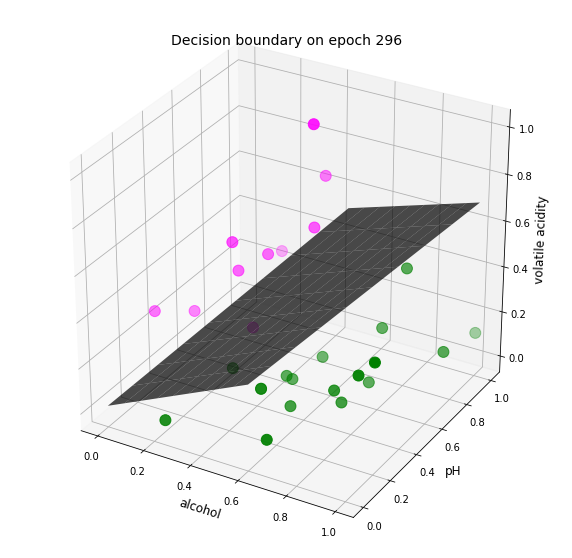

In [99]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np

def decision_boundary_3D(data, weights):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2],
               color=data['quality'].apply(lambda x: 'green' if x >= 7 else 'magenta'), s=120)

    ax.set_xlabel(data.columns[0], size=12)
    ax.set_ylabel(data.columns[1], size=12)
    ax.set_zlabel(data.columns[2], size=12)
    ax.set_title('Decision boundary on epoch ' + str(performance[-1][0]), size=14)

    min_x = data.iloc[:, 0].min()
    max_x = data.iloc[:, 0].max()
    min_y = data.iloc[:, 1].min()
    max_y = data.iloc[:, 1].max()
    min_z = data.iloc[:, 2].min()
    max_z = data.iloc[:, 2].max()

    ax.set_xlim(min_x - 0.05, max_x + 0.05)
    ax.set_ylim(min_y - 0.05, max_y + 0.05)
    ax.set_zlim(min_z - 0.05, max_z + 0.05)

    # point  = [0,0,0]
    weights = np.array(weights)
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 10), np.linspace(min_y, max_y, 10))
    z = (-weights[1]*xx - weights[2]*yy - weights[0])*1./weights[3]
    ax.plot_surface(xx, yy, z, color='k', alpha=0.7);
    return fig

    
data = red_wine_data.loc[:, ['alcohol', 'pH', 'volatile acidity', 'quality']].copy()
data = data.loc[(data['quality'] >= 8) | (data['quality'] <= 3)]
data['binary_quality'] = data['quality'].map({8: 1, 3: -1})

data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

train_data, test_data = train_test_split(data)
performance = adaline_train(0.005, train_data.drop('quality', axis=1), 0, mode='online')

weights = [performance[-1][-1]]
weights.extend(performance[-1][-2])

fig = decision_boundary_3D(data, weights)

## In ddition, playing with white wine data)

In [ ]:
white_wine_data = pd.read_csv("winequality-white.csv", sep=';')

data = white_wine_data.loc[(white_wine_data['quality'] >= 8) | (white_wine_data['quality'] <= 4)].copy()
data['binary_quality'] = data['quality'].map({9: 1, 8: 1, 3: -1, 7: 1, 4: -1})

data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

score = cross_validation(data.drop('quality', axis=1), adaline_train,
                         n_folds=3, n_epochs=0, method='batch', l_rate=0.005)
print("score: " + str(score))

data = white_wine_data.loc[:, ['alcohol', 'pH', 'sulphates', 'quality']].copy()
data = data.loc[(data['quality'] >= 8) | (data['quality'] <= 4)]
data['binary_quality'] = data['quality'].map({9: 1, 8: 1, 3: -1, 7: 1, 4: -1})
data.iloc[:, :-2] = normalizing(data.iloc[:, :-2])

train_data, test_data = train_test_split(data)
performance = adaline_train(0.005, train_data.drop('quality', axis=1), 0, mode='online')
weights = performance[-1][-2][:]
weights.insert(0, performance[-1][-1])
decision_boundary_3D(data, weights)